**Objective:** 

In this tutorial we will create a simple magnetic problem from scratch using the SimPEG framework.

We are using the integral form of the magnetostatic problem. In the absence of free-currents or changing magnetic field, magnetic material can give rise to a secondary magnetic field according to:

$$\vec b = \frac{\mu_0}{4\pi}  \int_{V}   \vec M \cdot \nabla \nabla \left(\frac{1}{r}\right) \; dV $$

Where $\mu_0$ is the magnetic permealitity of free-space, $\vec M$ is the magnetization per unit volume and $r$  defines the distance between the observed field $\vec b$ and the magnetized object. Assuming a purely induced response, the strenght of magnetization can be written as:

$$ \vec M = \mu_0 \kappa \vec H_0 $$

where $\vec H$ is an external inducing magnetic field, and $\kappa$ the magnetic susceptibility of matter.
As derived by Sharma 1966, the integral can be evaluated for rectangular prisms such that:

$$ \vec b(P) =  \mathbf{T} \cdot \vec H_0 \; \kappa $$

Where the tensor matrix $\bf{T}$ relates the three components of magnetization $\vec M$ to the components of the field $\vec b$:

$$\mathbf{T} =
	 \begin{pmatrix}
       		T_{xx} & T_{xy} & T_{xz}    \\
		T_{yx} & T_{yy} & T_{yz}    \\
		T_{zx} & T_{zy} & T_{zz}           
	\end{pmatrix} $$
    
In general, we discretize the earth into a collection of cells, each contributing to the magnetic data such that:

$$\vec b(P) = \sum_{j=1}^{nc} \mathbf{T}_j \cdot \vec H_0 \; \kappa_j$$

giving rise to a linear problem.


In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, DataMisfit, Inversion, Utils, Regularization
import SimPEG.PF as PF
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# First we need to define the direction of the inducing field
# As a simple case, we pick a vertical inducing field of magnitude 50,000nT. 
# From old convention, field orientation is given as an azimuth from North 
# (positive clockwise) and dip from the horizontal (positive downward).
H0 = (50000., 90.,0.)

# Assume all induced so the magnetization M is also in the same direction
M = np.array([90,0])

# Create a mesh
hxind = [(5,20,-1.3), (5, 20),(5,10,1.3)]
hyind = [(5,10,-1.3), (5, 20),(5,10,1.3)]
hzind = [(5, 10), (5,10,1.3)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

# Assume flat topo for now, so all cells are active
nC   = mesh.nC 
actv = np.asarray(range(mesh.nC))


# Create and array of observation points
xr = np.linspace(-20., 20., 20)
yr = np.linspace(-20., 20., 20)
X, Y = np.meshgrid(xr, yr)
Z = np.ones(X.size)*(mesh.vectorNz[-1]+1.) # Let just put the observation flat

# Create a MAGsurvey
xyzLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseMag.RxObs(xyzLoc)
srcField = PF.BaseMag.SrcField([rxLoc], param=H0)
survey = PF.BaseMag.LinearSurvey(srcField) 


Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, the system would looks like this:

$$ b_x =
	\begin{bmatrix}
	T_{xx}^1 &... &T_{xx}^{nc} & T_{xy}^1 & ... & T_{xy}^{nc} & T_{xz}^1 & ... & T_{xz}^{nc}\\
	 \end{bmatrix}
	 \begin{bmatrix}
		\mathbf{M}_x \\ \mathbf{M}_y \\ \mathbf{M}_z
	\end{bmatrix} \\ $$

where each of $T_{xx},\;T_{xy},\;T_{xz}$ are [nc x 1] long. For the $y$ and $z$ component, we need the two other rows of the tensor $\mathbf{T}$.
In our simple induced case, the magnetization direction $\mathbf{M_x,\;M_y\;,Mz}$ are known and assumed to be constant everywhere, so we can reduce the size of the system such that: 

$$ \vec{\mathbf{d}}_{\text{pred}} = (\mathbf{T\cdot M})\; \kappa$$



In most geophysical surveys, we are not collecting all three components, but rather the magnitude of the field, or $Total\;Magnetic\;Intensity$ (TMI) data.
Because the inducing field is really large, we will assume that the anomalous fields are parallel to $H_0$:

$$ d^{TMI}  = \hat H_0 \cdot \vec d$$

We then end up with a much smaller system:

$$ d^{TMI} = \mathbf{F\; \kappa}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [11]:
# First, convert the magnetization direction to Cartesian
# mi = np.ones(mesh.nC) * M[1]
# md = np.ones(mesh.nC) * M[2]
# M_xyz = PF.Magnetics.dipazm_2_xyz( mi , md ) # Ouputs an nc x 3 array

# We can now create a susceptibility model and generate data
# Lets start with a simple block in half-space
model = np.zeros((mesh.nCx,mesh.nCy,mesh.nCz))
model[8:11,8:11,6:9] = 0.01
model = Utils.mkvc(model)

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP = int(mesh.nC))

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap = idenMap, actInd = actv)

# Pair the survey and problem
survey.pair(prob)

# Compute linear forward operator and compute some data
data = prob.fields(model)

Begin forward: M=H0, Rx type= tmi
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %


<IPython.core.display.Javascript object>


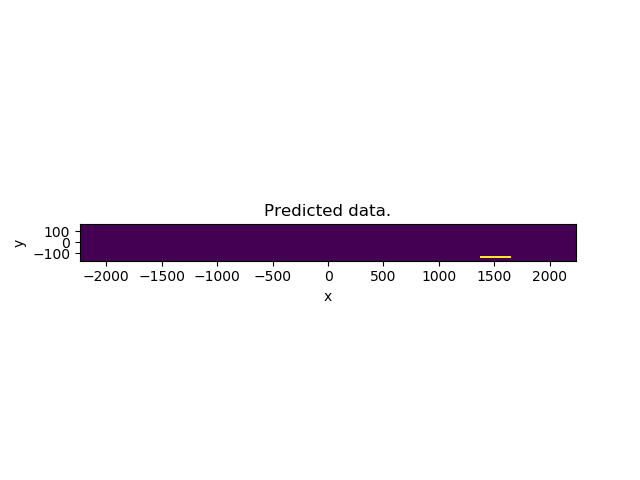

<IPython.core.display.Javascript object>


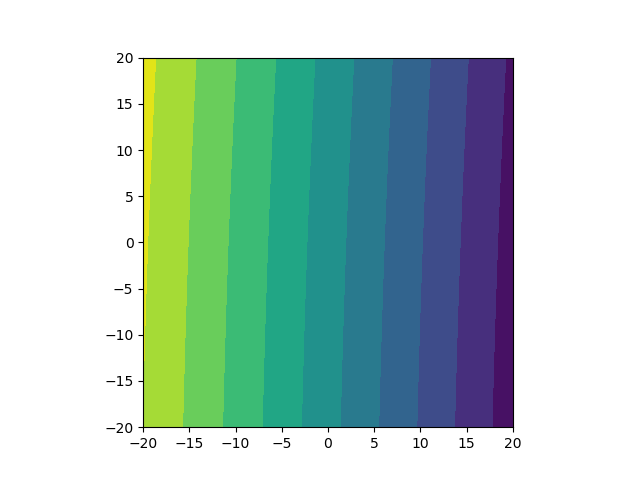

In [12]:

# Create a few models
plt.figure()
ax = plt.subplot()
mesh.plotSlice(model, ax = ax, normal = 'Y', ind=10)
ax.set_title('A simple block model.')
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# We can now generate data
#data = F.dot(model)  #: this is matrix multiplication!!
Utils.plot2Ddata(xyzLoc, data)
ax.set_title('Predicted data.')
plt.gca().set_aspect('equal', adjustable='box')


Once we have our problem, we can use the inversion tools in SimPEG to run our inversion:

In [114]:
#survey.makeSyntheticData(data, std=0.01)
survey.dobs=data
survey.std = np.ones(len(data))


# Create sensitivity weights from our linear forward operator
rxLoc = survey.srcField.rxList[0].locs
wr = np.zeros(prob.G.shape[1])
for ii in range(survey.nD):
    wr += (prob.G[ii, :]/survey.std[ii])**2.

# wr = (wr/np.max(wr))
wr = wr**0.5

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
# reg.norms = driver.lpnorms

# if driver.eps is not None:
#     reg.eps_p = driver.eps[0]
#     reg.eps_q = driver.eps[1]

reg.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg.mref = np.zeros(mesh.nC)
# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=20, lower=0., upper=10.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3, maxIRLSiter=10)
update_Jacobi = Directives.Update_lin_PreCond()

# saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap)
# saveModel.fileName = work_dir + out_dir + 'ModelSus'

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(mesh.nC)  * 1e-4# Starting model
prob.model = m0
mrec = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.14e+06  1.24e+05  1.62e-02  1.42e+05    3.32e+02      0              
   1  5.72e+05  1.16e+05  6.60e-03  1.19e+05    4.62e+02      0              
   2  2.86e+05  1.03e+05  2.33e-02  1.09e+05    4.57e+02      0              
   3  1.43e+05  8.47e+04  6.91e-02  9.46e+04    4.32e+02      0   Skip BFGS  
   4  7.15e+04  6.35e+04  1.77e-01  7.61e+04    4.19e+02      0   Skip BFGS  
   5  3.58e+04  4.23e+04  3.89e-01  5.62e+04    4.00e+02      0   Skip BFGS  
   6  1.79e+04  2.45e+04  7.43e-01  3.78e+04   

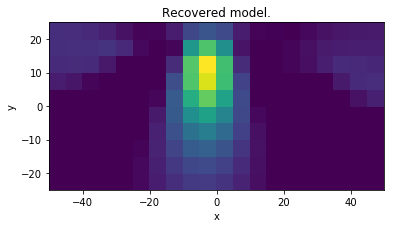

In [115]:
plt.figure()
ax = plt.subplot()
mesh.plotSlice(mrec, ax = ax, normal = 'Y', ind=10)
ax.set_title('Recovered model.')
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Hopefully you now have an idea of how to create a Problem class in SimPEG, and how this can be used with the other tools available.

In [108]:
m = np.ones(prob.G.shape[1])
def JtJv(v):

    Jv = prob.Jvec(m, v)

    return prob.Jtvec(m, Jv)

JtJdiag = Utils.diagEst(JtJv, len(m0), k=2000,approach='Probing')

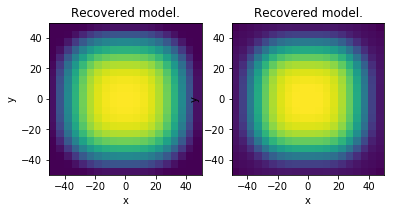

In [109]:
ind = -5
normal = 'Z'
# vmin = wr.min()
# vmax = wr.max()

plt.figure()
ax = plt.subplot(1,2,1)
mesh.plotSlice(np.log10(np.abs(JtJdiag)**0.5), ax = ax, normal=normal, ind=ind)
ax.set_title('Recovered model.')
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')

ax = plt.subplot(1,2,2)
mesh.plotSlice(np.log10(wr), ax = ax, normal=normal, ind=ind)
ax.set_title('Recovered model.')
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [111]:
print(np.log10(np.abs(JtJdiag)**0.5).min(), np.log10(wr).min())

-0.106040659523 0.804634839591
